In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
############
from sklearn.linear_model import Lasso,Ridge
############
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay,RocCurveDisplay,auc
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix


# Summary
In this part, i would like to stratify my data after tumor dianosis stages. So first, i will try to run Random forest on each stage to predict survival and non survival. The first around 25 importance features are then gathered and with that, i rerun Random forest classifier. 

# Data sumamry

In [3]:
df = pd.read_csv("../results/gene_exp_analysis/cnv_genes_exp.combine.csv",
                 header=0,sep="\t")
label = pd.read_csv("../results/gene_exp_analysis/clinical.csv",
                    header=0,sep="\t")

In [4]:
label2 = label[label.values  == 2]
label2 = label2.set_index('sample')

label3 = label[label.values  == 3]
label3 = label3.set_index('sample')

label4 = label[label.values  == 4]
label4 = label4.set_index('sample')

In [5]:
label2["OS"].value_counts(),label3["OS"].value_counts(),label4["OS"].value_counts(),

(OS
 0    95
 1    37
 Name: count, dtype: int64,
 OS
 0    84
 1    64
 Name: count, dtype: int64,
 OS
 1    89
 0    50
 Name: count, dtype: int64)

In [6]:
genes = df["genes"]
df = df.drop("genes",axis=1)
df = df.T
df2 = df.loc[label2.index]
df3 = df.loc[label3.index]
df4 = df.loc[label4.index]

# Data Augmentation

In [7]:
synthetic_samples = {
    0: 100,  # Number of synthetic samples for class 1
    1: 100,  # Number of synthetic samples for class 2
    # Add more classes and desired synthetic sample counts as needed
}
smote = SMOTE(sampling_strategy=synthetic_samples)

# Feature selection

In [8]:
# # LASSO model:
# lasso = Lasso(alpha=0.05)
# # fitting the model:
# lasso.fit(X, y)
# # select all coefficients and the feature names
# lasso_coefs = lasso.coef_
# feature_names = X.columns

# # collect the selected features:
# selected_feature_indices = np.nonzero(lasso_coefs)[0]
# selected_features = [feature_names[i] for i in selected_feature_indices]
# X_selected = X.iloc[:, selected_feature_indices]

# Machine learning model

In [9]:
model=RandomForestClassifier(random_state=42)

# defining parameter range
param_grid = { 
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [10,12,14,16,20],
    'criterion' :['gini', 'entropy']
}

In [10]:
def ml_method(X,y,model,param_grid,over_sample=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
    if over_sample:
        X_train,y_train = smote.fit_resample(X_train, y_train)
    grid = GridSearchCV(model, param_grid, refit = True, verbose = 1)
    
    # fitting the model for grid search
    grid.fit(X_train, y_train)
    grid_predictions = grid.predict(X_test)
    trained_model = grid.best_estimator_
    trained_model.fit(X_train,y_train)
    return X_train, X_test, y_train, y_test, grid_predictions, trained_model

In [11]:
def roc(X_train,y_train,model,label):
    cv = StratifiedKFold(n_splits=6)
    classifier = model
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X_train, y_train)):
        classifier.fit(X_train.iloc[train], y_train[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_train.iloc[test],
            y_train[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=label,
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    plt.show()


# Stage 2

In [12]:
X_train,X_test,y_train,y_test,grid_predictions,trained_model = ml_method(df2,label2["OS"],model,param_grid,over_sample=True)
important_feat = trained_model.feature_importances_
#get indices of those important features
stage2_features = important_feat.argsort(kind= "quicksort")
print(classification_report(y_test, grid_predictions))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


              precision    recall  f1-score   support

           0       0.80      0.90      0.85        31
           1       0.40      0.22      0.29         9

    accuracy                           0.75        40
   macro avg       0.60      0.56      0.57        40
weighted avg       0.71      0.75      0.72        40



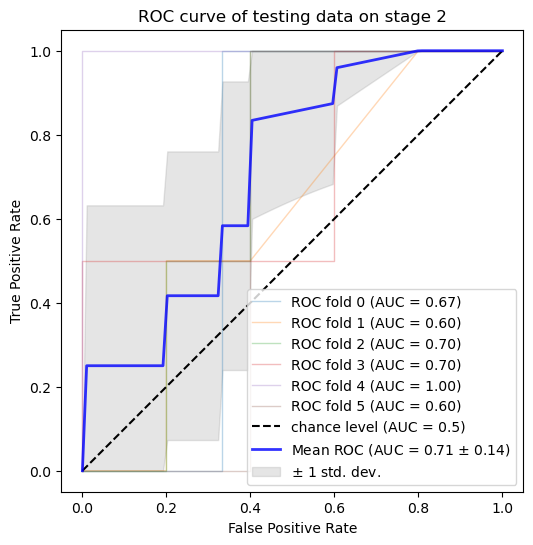

In [13]:
title="ROC curve of testing data on stage 2"
roc(X_test,y_test,trained_model,title)

# Stage 3

In [14]:
X_train,X_test,y_train,y_test,grid_predictions,trained_model = ml_method(df3,label3["OS"],model,param_grid,over_sample=True)
important_feat = trained_model.feature_importances_
#get indices of those important features
stage3_features = important_feat.argsort(kind= "quicksort")
print(classification_report(y_test, grid_predictions))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


              precision    recall  f1-score   support

           0       0.61      0.77      0.68        26
           1       0.50      0.32      0.39        19

    accuracy                           0.58        45
   macro avg       0.55      0.54      0.53        45
weighted avg       0.56      0.58      0.56        45



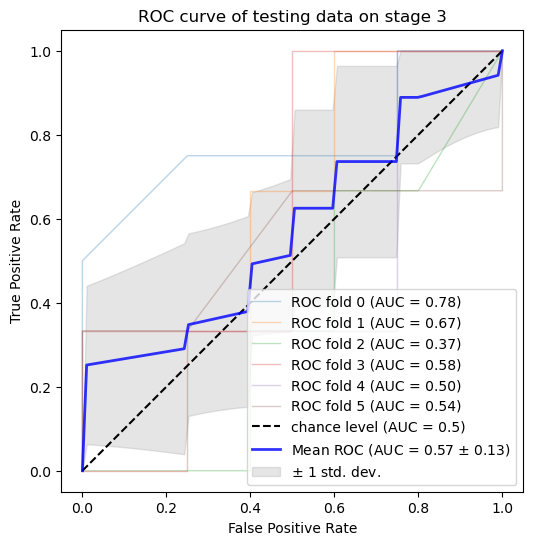

In [15]:
title="ROC curve of testing data on stage 3"
roc(X_test,y_test,trained_model,title)

# Stage 4

In [16]:
X_train,X_test,y_train,y_test,grid_predictions,trained_model = ml_method(df4,label4["OS"],model,param_grid,over_sample=True)
important_feat = trained_model.feature_importances_
#get indices of those important features
stage4_features = important_feat.argsort(kind= "quicksort")
print(classification_report(y_test, grid_predictions))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.54      0.80      0.65        25

    accuracy                           0.48        42
   macro avg       0.27      0.40      0.32        42
weighted avg       0.32      0.48      0.38        42



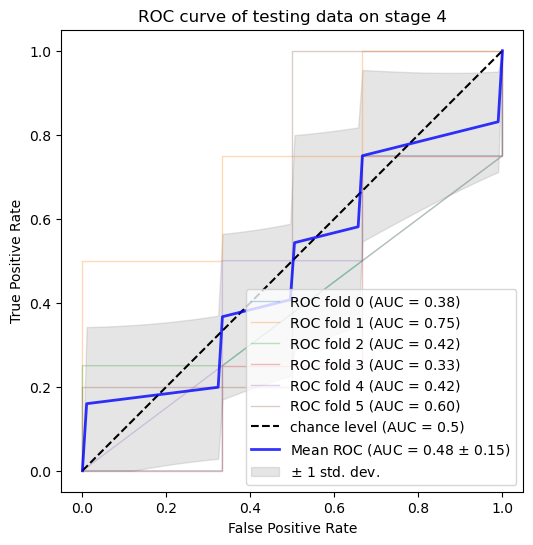

In [17]:
title="ROC curve of testing data on stage 4"
roc(X_test,y_test,trained_model,title)

# Feature importance

In [21]:
numb_features = 100
stage2_features = stage2_features[::-1][:numb_features]
stage3_features = stage3_features[::-1][:numb_features]
stage4_features = stage4_features[::-1][:numb_features]
##############
set1 = set(stage2_features)
set2 = set(stage3_features)
set3 = set(stage4_features)

intersection = list(set1.intersection(set2, set3))
print(len(intersection))

20


In [26]:
genes.loc[intersection]

1      ENSG00000004776
134    ENSG00000168813
7      ENSG00000049449
11     ENSG00000072818
141    ENSG00000170881
145    ENSG00000171551
41     ENSG00000118420
171    ENSG00000187068
44     ENSG00000119878
48     ENSG00000125970
51     ENSG00000132361
180    ENSG00000197253
57     ENSG00000134058
79     ENSG00000143184
81     ENSG00000143318
89     ENSG00000147647
222    ENSG00000233532
95     ENSG00000152382
121    ENSG00000164236
122    ENSG00000164307
Name: genes, dtype: object

In [22]:
intersection

[1,
 134,
 7,
 11,
 141,
 145,
 41,
 171,
 44,
 48,
 51,
 180,
 57,
 79,
 81,
 89,
 222,
 95,
 121,
 122]

# Retraining the model with features importance

In [19]:
df_retrain = df[intersection]
X_train,X_test,y_train,y_test,grid_predictions,trained_model = ml_method(df_retrain,label["OS"],model,param_grid)
print(classification_report(y_test, grid_predictions))


Fitting 5 folds for each of 20 candidates, totalling 100 fits


              precision    recall  f1-score   support

           0       0.62      0.81      0.70        63
           1       0.73      0.52      0.61        64

    accuracy                           0.66       127
   macro avg       0.68      0.66      0.65       127
weighted avg       0.68      0.66      0.65       127



# Multiclass prediction
In this part, i will try to classify after cancer stages.